# Árvore de decisão para atributos contínuos

In [7]:
#carregando o datase Wine
from sklearn.datasets import load_wine
dataset = load_wine()
X, y = dataset.data, dataset.target

In [8]:
#exibe a descrição do dataset e suas características
print(dataset.DESCR)
print(dataset.feature_names)
print(dataset.target_names)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

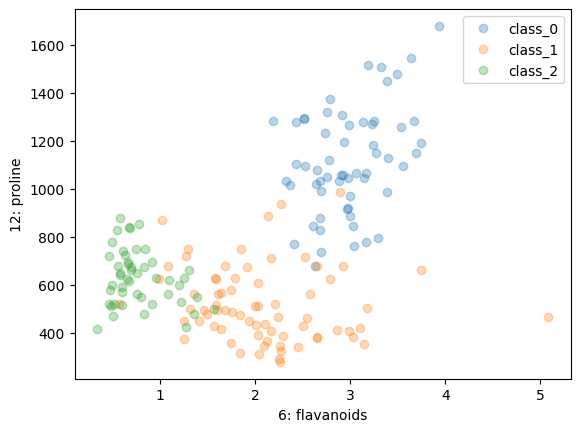

In [9]:
#plota o gráfico com as características 6 (Flavanoids) e 12 (Proline)
import matplotlib.pyplot as plt
i, j = 6, 12
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")

for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], 'o', alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

In [11]:
#exibe a quantidade de amostras para cada classe.
#a classe 1 é a que possui mais amostras (79)
#o dataset possui 178 amostras no total
from collections import Counter
print(Counter(y.flat))
print(len(y))

Counter({1: 71, 0: 59, 2: 48})
178


In [13]:
#implementa o modelo ZeroR que considera a classificação mais frequente
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    y[:] = self.resposta
    return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.38888889, 0.38888889, 0.38888889, 0.4       , 0.42857143]),
 0.3990476190476191)

In [14]:
modelo = ZeroR()
modelo.fit(X, y)
modelo.resposta

1

In [15]:
#como esperado, retorna o percentual da classe 1 (71 dividido por 178)
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.398876404494382

In [17]:
#implementa um modelo de árvore de decisão baseado na característica 6 e na média dos seus valores
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica = 6
    self.valor = np.mean(X[:,self.caracteristica])
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.9325842696629213

In [18]:
#validação cruzada
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.58333333, 0.75      , 0.69444444, 0.85714286, 0.65714286]),
 0.7084126984126984)

In [19]:
#método de impureza Gini
def impureza(y):
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades ** 2)
  return result

impureza(y[:])

0.6583133442747129

In [24]:
#método para calcular a impureza de um determinado valor
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

#exibe a impureza na característica 6 para o valor 2.3
impurezaValor(X[:,6], y, 2.3)

(0.44960290571593275, 0.5089697088520733, 0.3717321639399561)

In [51]:
#escolhe mo melhor valor baseado na menor impureza e na média dos valores mínimo e máximo
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break

  return result, menorImpureza

#exibe o melhor valor para a característica 6
melhorValor(X[:,6], y)

(2.71, 0.5276268675145079)

In [29]:
#método para definir a melhor característica de acordo com a menor impureza
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

# a característica 12 é a considerada a melhor característica
melhorCaracteristica(X, y)

(0.43761750381193476, 12, 979.0)

In [54]:
#altera o modelo de árvore de decisão para considerar a melhor característica
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
#exibe o tempo de execução para comparação posterior
%timeit modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

155 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


1.0

In [35]:
#há uma melhora significativa do modelo (passando de 0.7084 para 0.8942)
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.77777778, 0.88888889, 0.83333333, 1.        , 0.97142857]),
 0.8942857142857144)

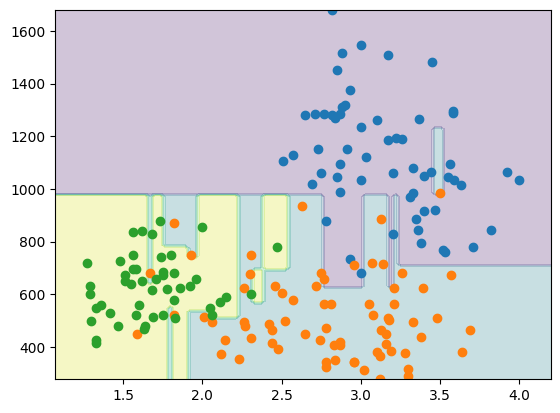

In [36]:
#plotagem dos gráficos
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
  modelo.fit(X, y)
  x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
  x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  Xdec = np.c_[x0.ravel(), x1.ravel()]
  ypred = modelo.predict(Xdec)
  plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
  for k in set(y):
    plt.plot(X[:,0][y==k], X[:,1][y==k], 'o')
  plt.show()

#visualiza o modelo de árvore de decisão implementado para as características 11 e 12
plotDecisao(Arvore(), X[:,11:], y)

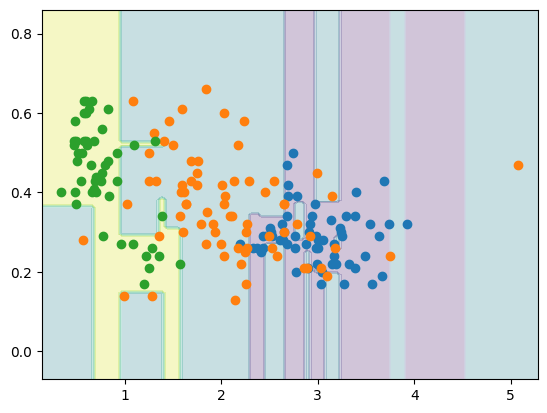

In [37]:
#visualiza o modelo de árvore de decisão implementado para as características 6 e 7
plotDecisao(Arvore(), X[:,6:8], y)

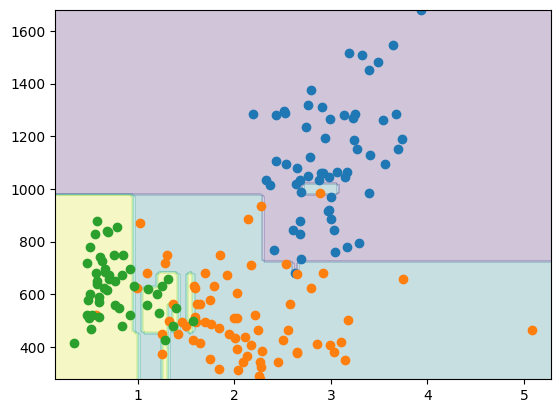

In [38]:
#visualiza o modelo de árvore de decisão implementado para as características 6 e 12
plotDecisao(Arvore(), X[:,[6,12]], y)

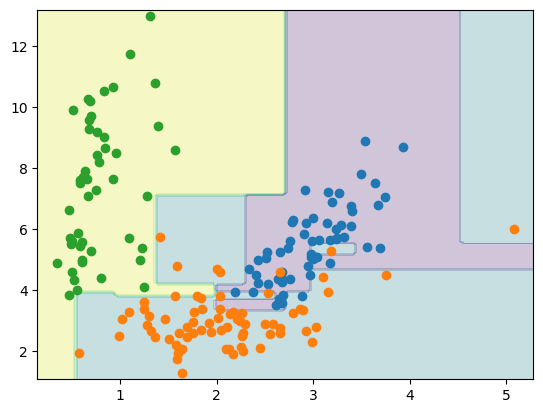

In [39]:
#visualiza o modelo de árvore de decisão implementado para as características 6 e 9
plotDecisao(Arvore(), X[:,[6,9]], y)

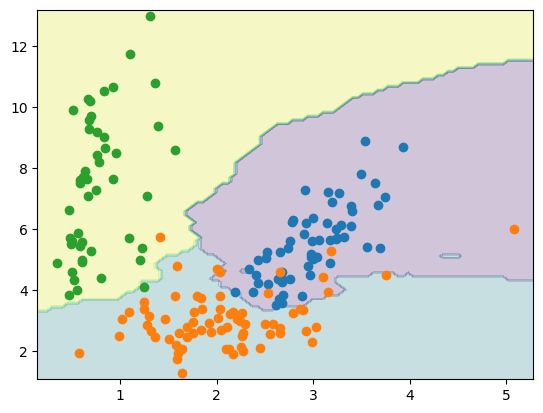

In [ ]:
#visualiza o modelo KNN para as características 6 e 9
from sklearn.neighbors import KNeighborsClassifier
plotDecisao(KNeighborsClassifier(), X[:,[6,9]], y)

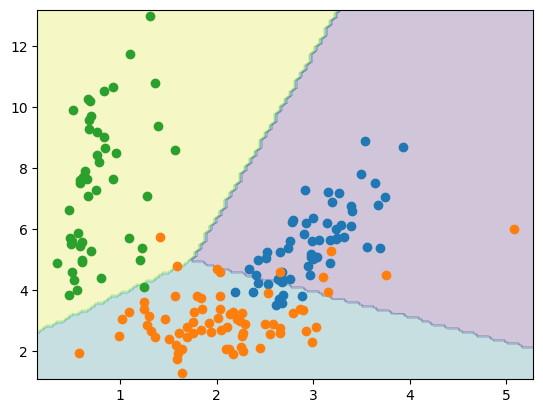

In [40]:
#visualiza o modelo LinearSVC para as características 6 e 9
from sklearn.svm import LinearSVC
plotDecisao(LinearSVC(max_iter=5000), X[:,[6,9]], y)

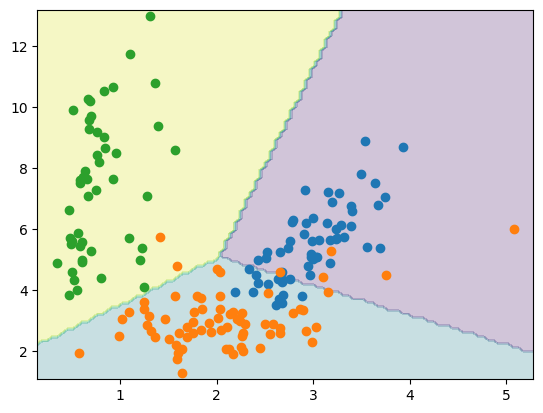

In [41]:
#visualiza o modelo Perceptron para as características 6 e 9
from sklearn.linear_model import Perceptron
plotDecisao(Perceptron(), X[:,[6,9]], y)

# Alteração da heurística de uma Árvore de decisão para atributos contínuos

In [43]:
# alteração da função melhorValor, de forma que esta busque todos os valores de
# cada característica que seja a média entre duas instâncias consecutivas,
# em relação à ordem dos valores daquela característica.
from operator import itemgetter

def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  if (len(x) == 1):
    return x[0], 0

  xs = sorted(x)

  for i in range(len(xs) - 1):
    x1 = xs[i]
    x2 = xs[i+1]
    valor = (x1+x2)/2
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
  return result, menorImpureza

#exibe o melhor valor para a característica 6 com a nova heurística
melhorValor(X[:,6], y)

#resultado com a heurística anterior -> (2.71, 0.5276268675145079)

(1.4, 0.43799046320416135)

In [44]:
# a característica 12 ainda é considerada a melhor característica, porém com outro valor
melhorCaracteristica(X, y)

#resultado com a heurística anterior -> (0.43761750381193476, 12, 979.0)

(0.4065279433382736, 12, 750.0)

In [47]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
%timeit modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

2.31 s ± 380 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


1.0

In [48]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.91666667, 0.83333333, 0.86111111, 0.91428571, 0.85714286]),
 0.8765079365079365)

**Conclusão:**

***Qual heurística apresenta melhor desempenho de classificação no novo dataset?***

De acordo com a validação cruzada, houve uma piora no desempenho com a nova heurística (média do test_score passou de 0.8942 para 0.8765)

***Qual heurística treina seus modelos mais rapidamente?***

Houve uma piora considerável no tempo de treinamento do modelo. Passando de **155 ms** com a heurística anterior para **2.31 s** com a nova heurística.